In [1]:
import os
import torch
torch.cuda.empty_cache()
import pickle,time,sys
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
import matplotlib
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from scipy.signal import medfilt
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, f1_score
import torch.optim as optim
import torch.nn.functional as F
import seaborn as sns
from scipy import signal
from einops import rearrange
from torch.utils.tensorboard import SummaryWriter
import argparse
from tqdm import tqdm

In [2]:
def load_pickle(file_path):
    try:
        print(f"Loading: {file_path}")
        with open(file_path, 'rb') as f:
            return pickle.load(f)
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

# Define file paths
path_afib_aflt = '/home/arizmahm1/folder1/CGAN/PTBXL-AF-NORM Data/X_afib_aflt.pkl'
path_norm = '/home/arizmahm1/folder1/CGAN/PTBXL-AF-NORM Data/X_norm.pkl'
path_y_afib_aflt = '/home/arizmahm1/folder1/CGAN/PTBXL-AF-NORM Data/Y_afib_aflt.pkl'
path_y_norm = '/home/arizmahm1/folder1/CGAN/PTBXL-AF-NORM Data/Y_norm.pkl'

# Load all files
X_afib_aflt = load_pickle(path_afib_aflt)
X_norm = load_pickle(path_norm)
Y_afib_aflt = load_pickle(path_y_afib_aflt)
Y_norm = load_pickle(path_y_norm)
# Print loaded data info
if X_afib_aflt is not None:
    print("X_afib_aflt:", type(X_afib_aflt), len(X_afib_aflt))
if X_norm is not None:
    print("X_norm:", type(X_norm), len(X_norm))
if Y_afib_aflt is not None:
    print("Y_afib_aflt:", type(Y_afib_aflt), len(Y_afib_aflt))
if Y_norm is not None:
    print("Y_norm:", type(Y_norm), len(Y_norm))

Loading: /home/arizmahm1/folder1/CGAN/PTBXL-AF-NORM Data/X_afib_aflt.pkl
Loading: /home/arizmahm1/folder1/CGAN/PTBXL-AF-NORM Data/X_norm.pkl


Loading: /home/arizmahm1/folder1/CGAN/PTBXL-AF-NORM Data/Y_afib_aflt.pkl
Loading: /home/arizmahm1/folder1/CGAN/PTBXL-AF-NORM Data/Y_norm.pkl
X_afib_aflt: <class 'numpy.ndarray'> 1570
X_norm: <class 'numpy.ndarray'> 9069
Y_afib_aflt: <class 'pandas.core.frame.DataFrame'> 1570
Y_norm: <class 'pandas.core.frame.DataFrame'> 9069


In [12]:
labels_norm = np.array([row for row in Y_norm['diagnostic_superclass']])

#  Randomly select 2000 samples
num_samples = 2000
random_indices = np.random.choice(len(X_norm), num_samples, replace=False)
norm_ecgs = X_norm[random_indices]
norm_labels = labels_norm[random_indices]
Y_afib_aflt = Y_afib_aflt[["diagnostic_superclass"]]
Y_afib_aflt["diagnostic_superclass"] = "AF"
Y_afib_aflt = Y_afib_aflt.to_numpy().reshape(-1, 1)
ecg_signals = np.concatenate((norm_ecgs, X_afib_aflt), axis=0)
ecgs_labels = np.concatenate((norm_labels, Y_afib_aflt), axis=0)
lead_II = ecg_signals[:, :, 1:2]  # Shape: (samples, timesteps, 1)
scaler = StandardScaler()
X_normalized = scaler.fit_transform(lead_II.reshape(-1, 1)).reshape(lead_II.shape)

# Median Filtering
window_size = 5
X_filtered = np.array([medfilt(x.squeeze(), kernel_size=window_size) for x in X_normalized])
X_filtered = X_filtered[..., np.newaxis]  # Reshape to (samples, timesteps, 1)

# Segment the signals
segment_length = 1000
X_segmented = np.array([
    x[i:i + segment_length] for x in X_filtered for i in range(0, len(x) - segment_length + 1, segment_length)
])
# Convert 'NORM' to 0 and 'AF' to 1
#ecgs_labels_numeric = np.where(ecgs_labels == 'NORM', 0, 1)
ecgs_labels_numeric = np.where(ecgs_labels == 'NORM', 0, 1)
# Split into training (64%) and temporary (36%) datasets
X_train, X_temp, y_train, y_temp = train_test_split(X_segmented, ecgs_labels_numeric, 
                                                    test_size=0.36, random_state=42, 
                                                    stratify=ecgs_labels)
# Split the temporary dataset into validation (25%) and test (20%) datasets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, 
                                                test_size=0.5556, random_state=42, 
                                                stratify=y_temp)

print("Training set class distribution:", dict(zip(*np.unique(y_train, return_counts=True))))
print("Validation set class distribution:", dict(zip(*np.unique(y_val, return_counts=True))))
print("Test set class distribution:", dict(zip(*np.unique(y_test, return_counts=True))))

Training set class distribution: {0: 1280, 1: 1004}
Validation set class distribution: {0: 320, 1: 251}
Test set class distribution: {0: 400, 1: 315}


In [3]:
class AdvP2PGenerator(nn.Module):
    def __init__(self, latent_dim, output_size=1000):
        super(AdvP2PGenerator, self).__init__()  # Correct the class name here

        self.latent_dim = latent_dim
        self.output_size = output_size
        # Embedding layer for labels
        self.label_embedding = nn.Embedding(2, latent_dim)  # Binary classification: 0 or 1
        # Fully connected layers to upscale the latent dimension
        self.fc1 = nn.Linear(latent_dim * 2, 1024)
        self.fc2 = nn.Linear(1024, 512 * (output_size // 16))  # Matches input size for ConvTranspose1D

        # Batch normalization
        self.bn1 = nn.BatchNorm1d(1024)
        self.bn2 = nn.BatchNorm1d(512)

        # Transposed Convolution Layers
        self.upsample = nn.Sequential(
            nn.ConvTranspose1d(512, 256, kernel_size=4, stride=2, padding=1),  # Output: output_size // 8
            nn.ReLU(),
            nn.ConvTranspose1d(256, 128, kernel_size=4, stride=2, padding=1),  # Output: output_size // 4
            nn.ReLU(),
            nn.ConvTranspose1d(128, 64, kernel_size=4, stride=2, padding=1),   # Output: output_size // 2
            nn.ReLU(),
            nn.ConvTranspose1d(64, 1, kernel_size=4, stride=2, padding=1),     # Output: slightly less than output_size
        )

        # Adjustment layer to ensure exact output size
        self.adjust = nn.Conv1d(1, 1, kernel_size=3, stride=1, padding=5)  # Keeps output size consistent

        # Final activation
        self.tanh = nn.Tanh()
    def forward(self, z, label):
    # Embed the label
        label_embedding = self.label_embedding(label)  # Shape: (batch_size, latent_dim)
        #print(f"Label embedding shape: {label_embedding.shape}")
        label_embedding = label_embedding.squeeze(1)                  ###### nEW ADDITION LINE 
        #print(f"Label embedding after sqeez shape: {label_embedding.shape}")
        # Ensure z is 2D with shape (batch_size, latent_dim)
        z = z.view(z.size(0), -1)  # Flatten to 2D
        #print(f"Z after flattening: {z.shape}")
        # Concatenate latent vector (z) and label embedding (label_embedding)
        x = torch.cat((z, label_embedding), dim=1)  # Shape: (batch_size, latent_dim * 2)
        #print(f"Shape after concatenation: {x.shape}")
        # Fully connected layers
        x = self.fc1(x)
        #print(f"Shape after fc1: {x.shape}")
        x = self.bn1(x)
        x = nn.ReLU()(x)
        #print(f"Shape after ReLU and bn1: {x.shape}")
        x = self.fc2(x)
        #print(f"Shape after fc2: {x.shape}")
        x = x.view(x.size(0), 512, -1)  # Reshape for ConvTranspose1D
        #print(f"Shape after reshaping for ConvTranspose1D: {x.shape}")
        x = self.bn2(x)
        x = nn.ReLU()(x)
        #print(f"Shape after ReLU and bn2: {x.shape}")
        # Upsample to the desired output size
        x = self.upsample(x)
        #print(f"Shape after upsampling: {x.shape}")
    
        # Adjust to ensure exact output size
        x = self.adjust(x)
        #print(f"Shape after adjust: {x.shape}")
    
        # Final activation
        output = self.tanh(x)
        #print(f"Shape after final activation (Tanh): {output.shape}")
    
        return output

In [4]:
class PhaseShuffle(nn.Module):
   
    def __init__(self, shift_factor):
        super(PhaseShuffle, self).__init__()
        self.shift_factor = shift_factor

    def forward(self, x):
        if self.shift_factor == 0:
            return x
        k_list = torch.Tensor(x.shape[0]).random_(0, 2 * self.shift_factor + 1) - self.shift_factor
        k_list = k_list.numpy().astype(int)

        k_map = {}
        for idx, k in enumerate(k_list):
            k = int(k)
            if k not in k_map:
                k_map[k] = []
            k_map[k].append(idx)

        x_shuffle = x.clone()

        for k, idxs in k_map.items():
            if k > 0:
                x_shuffle[idxs] = F.pad(x[idxs][..., :-k], (k, 0), mode='reflect')
            else:
                x_shuffle[idxs] = F.pad(x[idxs][..., -k:], (0, -k), mode='reflect')

        assert x_shuffle.shape == x.shape, "{}, {}".format(x_shuffle.shape, x.shape)
        return x_shuffle
class AdvP2PDiscriminator(nn.Module):
    def __init__(self, model_size=50, num_channels=1, shift_factor=2, alpha=0.2):
        super(AdvP2PDiscriminator, self).__init__()
        self.model_size = model_size 
        self.num_channels = num_channels 
        self.shift_factor = shift_factor  
        self.alpha = alpha

        # Using smaller kernel size (3) and adjusted padding for each layer
        self.conv1 = nn.Conv1d(num_channels, model_size, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv1d(model_size, 2 * model_size, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv1d(2 * model_size, 5 * model_size, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv1d(5 * model_size, 10 * model_size, kernel_size=3, stride=2, padding=1)
        self.conv5 = nn.Conv1d(10 * model_size, 20 * model_size, kernel_size=3, stride=2, padding=1)
        self.conv6 = nn.Conv1d(20 * model_size, 25 * model_size, kernel_size=3, stride=2, padding=1)
        self.conv7 = nn.Conv1d(25 * model_size, 100 * model_size, kernel_size=3, stride=2, padding=1)
        self.conv8 = nn.Conv1d(100 * model_size + 1, 200 * model_size, kernel_size=3, stride=1, padding=1)

        self.ps1 = PhaseShuffle(shift_factor)
        self.ps2 = PhaseShuffle(shift_factor)
        self.ps3 = PhaseShuffle(shift_factor)
        self.ps4 = PhaseShuffle(shift_factor)
        self.ps5 = PhaseShuffle(shift_factor)
        self.ps6 = PhaseShuffle(shift_factor)

        self.flat = nn.Flatten()

        self.fc1 = nn.Linear(200 * model_size * 8, 1)  # Adjust this based on final tensor size

        for m in self.modules():
            if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight.data)
   
    def forward(self, x, targets):
        #print(f"Initial input shape to discriminator: {x.shape}")
        
        # Permute input if necessary
        if x.shape[1] != 1:  # If input is not in [batch_size, 1, sequence_length]
            x = x.permute(0, 2, 1)  # Permute to [batch_size, channels, sequence_length]
            #print(f"Shape after permute in forward: {x.shape}")
        
        # Forward pass through convolutional layers
        x = F.leaky_relu(self.conv1(x), negative_slope=self.alpha)
        #print(f"Shape after conv1: {x.shape}")
        x = self.ps1(x)
    
        x = F.leaky_relu(self.conv2(x), negative_slope=self.alpha)
        #print(f"Shape after conv2: {x.shape}")
        x = self.ps2(x)
    
        x = F.leaky_relu(self.conv3(x), negative_slope=self.alpha)
        #print(f"Shape after conv3: {x.shape}")
        x = self.ps3(x)
    
        x = F.leaky_relu(self.conv4(x), negative_slope=self.alpha)
        #print(f"Shape after conv4: {x.shape}")
        x = self.ps4(x)
    
        x = F.leaky_relu(self.conv5(x), negative_slope=self.alpha)
        #print(f"Shape after conv5: {x.shape}")
        x = self.ps5(x)
    
        x = F.leaky_relu(self.conv6(x), negative_slope=self.alpha)
        #print(f"Shape after conv6: {x.shape}")
        x = self.ps6(x)
    
        x = F.leaky_relu(self.conv7(x), negative_slope=self.alpha)
        #print(f"Shape after conv7: {x.shape}")  # Expected: [batch_size, channels, sequence_length]
    
        # Ensure targets are in the correct shape
        if targets.ndim == 1:  # If targets are [batch_size]
            targets = targets.unsqueeze(-1)  # Add a new dimension: [batch_size, 1]
           #print(f"Targets shape after unsqueeze: {targets.shape}")
        # Expand targets to match x's sequence length
        targets = targets.unsqueeze(-1)  # Add another dimension: [batch_size, 1, 1]
        targets = targets.expand(-1, 1, x.size(2))  # Expand along sequence length: [batch_size, 1, sequence_length]
        #print(f"Targets shape after expand: {targets.shape}")
        # Concatenate targets with x along the channel dimension
        x = torch.cat([x, targets], dim=1)  # Concatenate along channel dimension
        #print(f"Shape after concatenation: {x.shape}")  # Expected: [batch_size, channels+1, sequence_length]
    
        # Further processing through convolution
        x = F.leaky_relu(self.conv8(x), negative_slope=self.alpha)
        #print(f"Shape after conv8: {x.shape}")
        # Flatten output for fully connected layer
        x = self.flat(x)
        #print(f"Shape after flattening: {x.shape}")
        return self.fc1(x)

In [5]:
class ECGDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)  # Ensure data is float32
        self.y = torch.tensor(y, dtype=torch.long).squeeze(-1)  # Ensure labels are 1D

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
def prepare_data(X_train, y_train, X_val, y_val, batch_size):    
    train_dataset = ECGDataset(X_train, y_train)
    val_dataset = ECGDataset(X_val, y_val)

    # Create DataLoader instances
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True
    )
    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True
    )
    # Debugging shape
   # print(f"Training DataLoader: {len(train_loader)} batches, batch size: {batch_size}")
    #print(f"Validation DataLoader: {len(val_loader)} batches, batch size: {batch_size}")
    
    return train_loader, val_loader

In [6]:
def calc_gradient_penalty(net_dis, real_data, fake_data, lmbda, device):
    batch_size = real_data.size(0)
    alpha = torch.rand(batch_size, 1, 1).to(device)
    interpolates = alpha * real_data + (1 - alpha) * fake_data
    interpolates = interpolates.requires_grad_(True)
    disc_interpolates = net_dis(interpolates, targets=torch.zeros_like(real_data[:, 0]))  # Adapt based on discriminator
    gradients = torch.autograd.grad(
        outputs=disc_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(disc_interpolates),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    gradients = gradients.view(batch_size, -1)  # Flatten
    gradient_penalty = lmbda * ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [7]:
#import os
sys.argv = ['']  # Reset sys.argv to avoid unnecessary arguments from the notebook
sys.argv.extend([
    '--exp_name', 'my_experiment',  # Example argument
    '--out_dir', './output',
    '--tensorboard_dir', './tensorboard',
    '--bs', '64',
    '--lr', '0.0001',
    '--num_epochs', '2000',
    '--lmbda', '10.0'
])

# Now you can use argparse as usual
parser = argparse.ArgumentParser()
parser.add_argument("--exp_name", type=str, required=True, help="Experiment name for saving outputs")
parser.add_argument("--out_dir", default="./output", help="Directory for saving outputs")
parser.add_argument("--tensorboard_dir", default="./tensorboard", help="Tensorboard output directory")
parser.add_argument("--bs", type=int, default=64, help="Batch size")
parser.add_argument("--lr", type=float, default=0.00001, help="Learning rate")
parser.add_argument("--num_epochs", type=int, default=2000, help="Number of training epochs")
parser.add_argument("--lmbda", type=float, default=10.0, help="Gradient penalty factor")
opt = parser.parse_args()

# Now you can access the arguments
print(opt.exp_name)
print(opt.lr)


# Output and logging directories
os.makedirs(opt.out_dir, exist_ok=True)
tensorboard_exp_dir = os.path.join(opt.tensorboard_dir, opt.exp_name)
os.makedirs(tensorboard_exp_dir, exist_ok=True)
writer = SummaryWriter(tensorboard_exp_dir)

my_experiment
0.0001


In [8]:
def plot_generated_ecgs(generator, epoch, num_samples=2):
    """Plot generated ECGs"""
    generator.eval()  # Set generator to evaluation mode
    z = torch.randn(num_samples, 100).to(device)  # Latent vector
    labels = torch.randint(0, 1, (num_samples,)).to(device)  # Random labels
    with torch.no_grad():
        fake_ecgs = generator(z, labels)  # Generate fake data
    fake_ecgs = fake_ecgs.squeeze(1).cpu().numpy()  # Remove channel dimension

    plt.figure(figsize=(20, 4))  # Adjust figure size for 2 plots
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.plot(fake_ecgs[i])
        plt.title(f"Label: {labels[i].item()}")
        plt.xlabel("Time Steps")
        plt.ylabel("Amplitude")
        plt.tight_layout()
    plt.suptitle(f"Generated ECGs at Epoch {epoch}")
    plt.show()

In [9]:


# Define the CNN feature extractor model
class CNNFeatureExtractor(nn.Module):
    def __init__(self):
        super(CNNFeatureExtractor, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(32)
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(32)
        self.conv4 = nn.Conv1d(in_channels=32, out_channels=16, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm1d(16)
        self.conv5 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm1d(16)
        self.conv6 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm1d(16)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.dropout = nn.Dropout(0.5)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16 * 15, 64)  # Update this based on input size
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.dropout(x)
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout(x)
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.dropout(x)
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.dropout(x)
        x = self.pool(F.relu(self.bn5(self.conv5(x))))
        x = self.dropout(x)
        x = self.pool(F.relu(self.bn6(self.conv6(x))))
        x = self.dropout(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))
        return x
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Step 1: Initialize the model
feature_extractor = CNNFeatureExtractor().to(device)  # Correct initialization of the model

# Step 2: Load the state dictionary into the model
state_dict = torch.load('/home/arizmahm1/folder1/CGAN/PTBXL-AF-NORM Data/best_feature_extractor.pth')
feature_extractor.load_state_dict(state_dict)

# Step 3: Set the model to evaluation mode (important for dropout and batchnorm layers)
feature_extractor.eval()

# Step 4: Ensure the model is moved to the appropriate device (GPU/CPU)

feature_extractor.to(device)



/tmp/ipykernel_369616/672664460.py:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('/home/arizmahm1/folder1/CGAN/PTBXL-AF-NORM Data/best_feature_ex

CNNFeatureExtractor(
  (conv1): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(64, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv1d(32, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn5): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn6): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool1d(

In [10]:

# Define additional loss functions
def dtw_loss(real_data, generated_data):
    return torch.mean(torch.abs(real_data - generated_data))  # Placeholder DTW implementation

def waveform_specific_loss(real_data, generated_data):
    return torch.mean(torch.abs(real_data - generated_data))

def calculate_correlation(real_data, generated_data):
    real_mean = torch.mean(real_data, dim=1, keepdim=True)
    gen_mean = torch.mean(generated_data, dim=1, keepdim=True)
    real_std = torch.std(real_data, dim=1, keepdim=True)
    gen_std = torch.std(generated_data, dim=1, keepdim=True)
    covariance = torch.mean((real_data - real_mean) * (generated_data - gen_mean), dim=1)
    correlation = covariance / (real_std * gen_std + 1e-10)
    return torch.mean(correlation)

def feature_matching_loss(real_output, fake_output):
    return torch.mean(torch.abs(torch.mean(real_output, dim=0) - torch.mean(fake_output, dim=0)))

'''def calculate_fid(real_samples, generated_samples, feature_extractor):
    real_features = feature_extractor(real_samples)
    gen_features = feature_extractor(generated_samples)
    mu_real, mu_gen = torch.mean(real_features, dim=0), torch.mean(gen_features, dim=0)
    sigma_real = torch.cov(real_features.T)
    sigma_gen = torch.cov(gen_features.T)
    diff = mu_real - mu_gen
    covmean = sqrtm((sigma_real @ sigma_gen).cpu().detach().numpy())
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    covmean = torch.tensor(covmean, dtype=torch.float32, device=real_samples.device)
    fid = torch.sum(diff**2) + torch.trace(sigma_real + sigma_gen - 2 * covmean)
    return fid'''


def calculate_fid(real_samples, generated_samples, feature_extractor):
    # Ensure real_samples and generated_samples are on the same device as the feature extractor
    device = real_samples.device
    real_samples = real_samples.to(device)
    generated_samples = generated_samples.to(device)

    # Extract features using the feature extractor
    real_features = feature_extractor(real_samples)
    gen_features = feature_extractor(generated_samples)

    # Calculate the mean and covariance of the features
    mu_real, mu_gen = torch.mean(real_features, dim=0), torch.mean(gen_features, dim=0)
    sigma_real = torch.cov(real_features.T)
    sigma_gen = torch.cov(gen_features.T)

    # Compute the FID score
    diff = mu_real - mu_gen
    covmean = sqrtm((sigma_real @ sigma_gen).cpu().detach().numpy())
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    covmean = torch.tensor(covmean, dtype=torch.float32, device=real_samples.device)

    # Final FID calculation
    fid = torch.sum(diff**2) + torch.trace(sigma_real + sigma_gen - 2 * covmean)
    return fid


def temporal_coherence_loss(real_data, generated_data):
    # Check if both tensors have the same number of time steps (dim 1)
    if real_data.size(1) != generated_data.size(1):
        raise ValueError("The time steps (dim 1) of real_data and generated_data must be the same")

    # Ensure that both tensors have at least 2 time steps
    if real_data.size(1) < 2:
        raise ValueError("Time steps (dim 1) must be at least 2 for temporal coherence loss")

    # Compute the difference between consecutive time steps
    diff_real = real_data[:, 1:, :] - real_data[:, :-1, :]
    diff_fake = generated_data[:, 1:, :] - generated_data[:, :-1, :]

    # Compute and return the mean squared error between the differences
    return torch.mean((diff_real - diff_fake) ** 2)


  0%|          | 0/36 [00:00<?, ?it/s]/home/arizmahm1/anaconda3/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|██████████| 36/36 [00:12<00:00,  2.88it/s]


Epoch 1/2000 - Loss G: 136.4962, Loss D: 37.0430


100%|██████████| 36/36 [00:11<00:00,  3.06it/s]


Epoch 2/2000 - Loss G: 116.4933, Loss D: 16.7968


100%|██████████| 36/36 [00:11<00:00,  3.05it/s]


Epoch 3/2000 - Loss G: 117.5418, Loss D: 13.5073


100%|██████████| 36/36 [00:11<00:00,  3.05it/s]


Epoch 4/2000 - Loss G: 108.1863, Loss D: 16.0878


100%|██████████| 36/36 [00:06<00:00,  5.24it/s]


Epoch 5/2000 - Loss G: 110.4820, Loss D: 13.7214


100%|██████████| 36/36 [00:05<00:00,  6.92it/s]


Epoch 6/2000 - Loss G: 109.2373, Loss D: 16.9945


100%|██████████| 36/36 [00:05<00:00,  6.92it/s]


Epoch 7/2000 - Loss G: 108.0981, Loss D: 14.1242


100%|██████████| 36/36 [00:05<00:00,  6.92it/s]


Epoch 8/2000 - Loss G: 109.3739, Loss D: 13.5011


100%|██████████| 36/36 [00:05<00:00,  6.91it/s]


Epoch 9/2000 - Loss G: 108.9941, Loss D: 16.5400


100%|██████████| 36/36 [00:05<00:00,  6.92it/s]


Epoch 10/2000 - Loss G: 112.6651, Loss D: 14.2284


100%|██████████| 36/36 [00:05<00:00,  6.91it/s]


Epoch 11/2000 - Loss G: 110.4085, Loss D: 12.4907


100%|██████████| 36/36 [00:05<00:00,  6.93it/s]


Epoch 12/2000 - Loss G: 111.9064, Loss D: 13.2420


100%|██████████| 36/36 [00:05<00:00,  6.92it/s]


Epoch 13/2000 - Loss G: 112.5708, Loss D: 13.2528


100%|██████████| 36/36 [00:05<00:00,  6.92it/s]


Epoch 14/2000 - Loss G: 112.8183, Loss D: 14.0478


100%|██████████| 36/36 [00:05<00:00,  6.92it/s]


Epoch 15/2000 - Loss G: 101.4677, Loss D: 30.0668


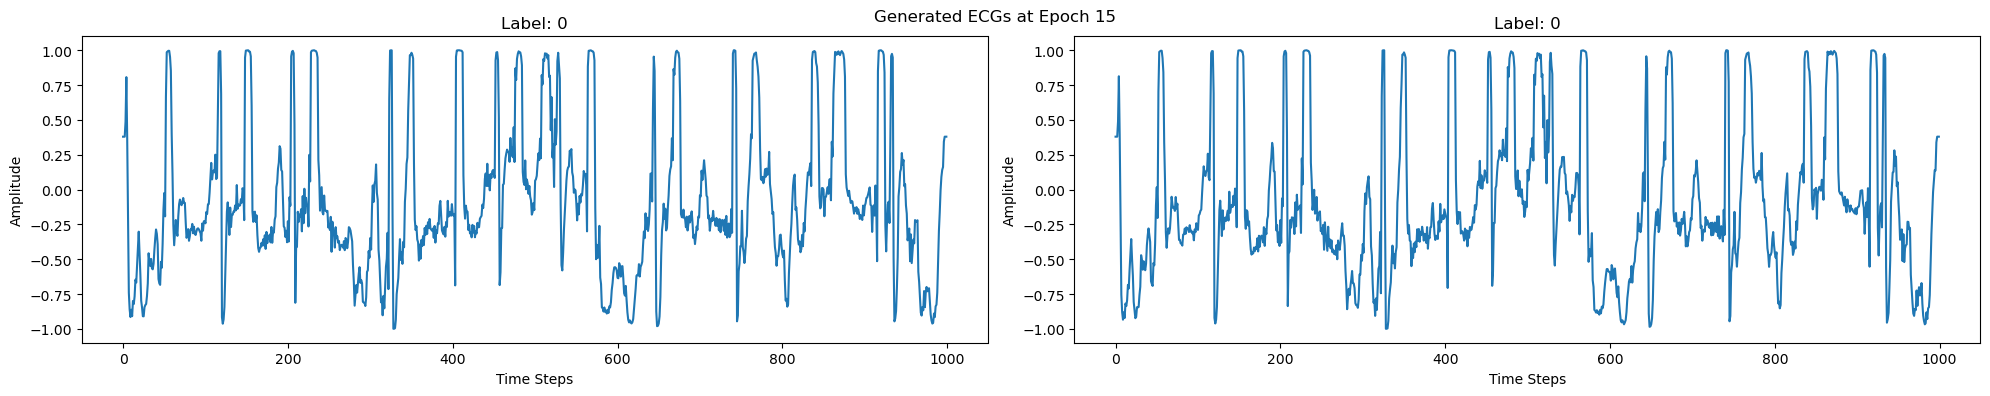

100%|██████████| 36/36 [00:05<00:00,  6.92it/s]


Epoch 16/2000 - Loss G: 111.2405, Loss D: 13.0753


100%|██████████| 36/36 [00:05<00:00,  6.93it/s]


Epoch 17/2000 - Loss G: 110.2989, Loss D: 13.2625


100%|██████████| 36/36 [00:05<00:00,  6.93it/s]


Epoch 18/2000 - Loss G: 111.0229, Loss D: 13.1556


100%|██████████| 36/36 [00:05<00:00,  6.93it/s]


Epoch 19/2000 - Loss G: 113.7046, Loss D: 12.5313


100%|██████████| 36/36 [00:05<00:00,  6.93it/s]


Epoch 20/2000 - Loss G: 112.7214, Loss D: 13.0306


100%|██████████| 36/36 [00:05<00:00,  6.91it/s]


Epoch 21/2000 - Loss G: 114.3747, Loss D: 11.9636


100%|██████████| 36/36 [00:05<00:00,  6.92it/s]


Epoch 22/2000 - Loss G: 116.3628, Loss D: 13.1508


100%|██████████| 36/36 [00:05<00:00,  6.92it/s]


Epoch 23/2000 - Loss G: 111.7587, Loss D: 15.2572


100%|██████████| 36/36 [00:05<00:00,  6.93it/s]


Epoch 24/2000 - Loss G: 110.7188, Loss D: 12.1461


100%|██████████| 36/36 [00:05<00:00,  6.93it/s]


Epoch 25/2000 - Loss G: 111.9526, Loss D: 12.4585


100%|██████████| 36/36 [00:05<00:00,  6.93it/s]


Epoch 26/2000 - Loss G: 114.5417, Loss D: 12.7477


100%|██████████| 36/36 [00:05<00:00,  6.93it/s]


Epoch 27/2000 - Loss G: 114.0150, Loss D: 12.1990


100%|██████████| 36/36 [00:05<00:00,  6.91it/s]


Epoch 28/2000 - Loss G: 114.5152, Loss D: 11.6061


100%|██████████| 36/36 [00:05<00:00,  6.92it/s]


Epoch 29/2000 - Loss G: 112.6645, Loss D: 12.7892


100%|██████████| 36/36 [00:05<00:00,  6.93it/s]


Epoch 30/2000 - Loss G: 119.3458, Loss D: 11.8521


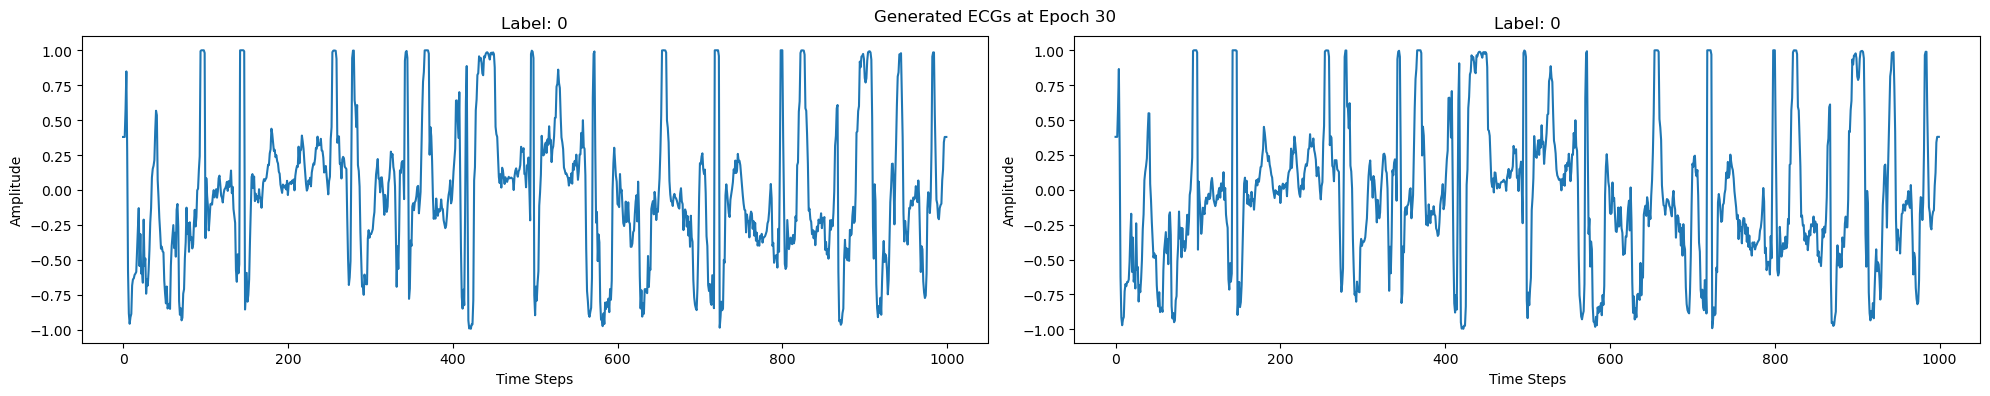

100%|██████████| 36/36 [00:05<00:00,  6.93it/s]


Epoch 31/2000 - Loss G: 120.4265, Loss D: 11.4796


100%|██████████| 36/36 [00:05<00:00,  6.92it/s]


Epoch 32/2000 - Loss G: 119.9331, Loss D: 11.8394


100%|██████████| 36/36 [00:05<00:00,  6.93it/s]


Epoch 33/2000 - Loss G: 118.6300, Loss D: 12.3895


100%|██████████| 36/36 [00:05<00:00,  6.92it/s]


Epoch 34/2000 - Loss G: 105.8688, Loss D: 22.8744


100%|██████████| 36/36 [00:05<00:00,  6.92it/s]


Epoch 35/2000 - Loss G: 105.8833, Loss D: 13.8290


100%|██████████| 36/36 [00:05<00:00,  6.92it/s]


Epoch 36/2000 - Loss G: 112.9465, Loss D: 12.5689


100%|██████████| 36/36 [00:05<00:00,  6.92it/s]


Epoch 37/2000 - Loss G: 112.6356, Loss D: 12.9654


100%|██████████| 36/36 [00:05<00:00,  6.93it/s]


Epoch 38/2000 - Loss G: 115.0157, Loss D: 11.1358


100%|██████████| 36/36 [00:05<00:00,  6.93it/s]


Epoch 39/2000 - Loss G: 112.4957, Loss D: 11.6692


100%|██████████| 36/36 [00:05<00:00,  6.93it/s]


Epoch 40/2000 - Loss G: 111.4932, Loss D: 12.7528


100%|██████████| 36/36 [00:05<00:00,  6.91it/s]


Epoch 41/2000 - Loss G: 113.7342, Loss D: 12.0824


100%|██████████| 36/36 [00:05<00:00,  6.91it/s]


Epoch 42/2000 - Loss G: 114.7281, Loss D: 12.5054


100%|██████████| 36/36 [00:05<00:00,  6.92it/s]


Epoch 43/2000 - Loss G: 116.2907, Loss D: 11.7896


100%|██████████| 36/36 [00:05<00:00,  6.92it/s]


Epoch 44/2000 - Loss G: 118.4070, Loss D: 13.1497


100%|██████████| 36/36 [00:05<00:00,  6.92it/s]


Epoch 45/2000 - Loss G: 111.7506, Loss D: 12.9703


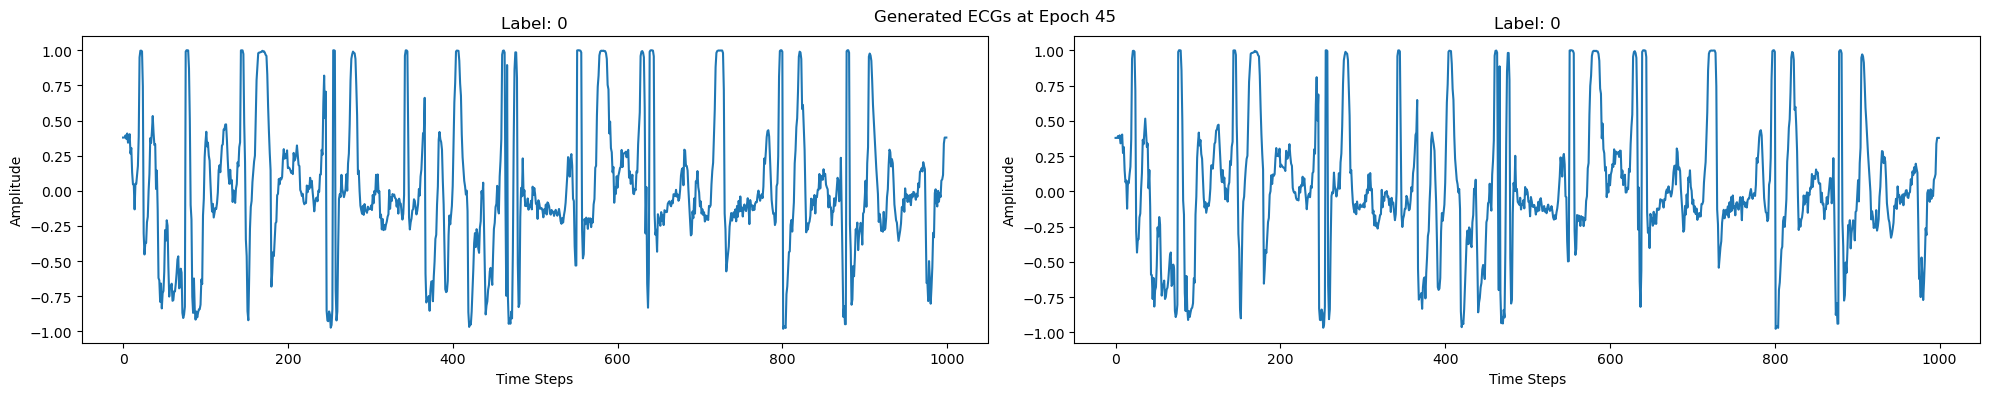

100%|██████████| 36/36 [00:05<00:00,  6.92it/s]


Epoch 46/2000 - Loss G: 117.1991, Loss D: 10.6876


100%|██████████| 36/36 [00:05<00:00,  6.91it/s]


Epoch 47/2000 - Loss G: 115.3498, Loss D: 11.9926


100%|██████████| 36/36 [00:05<00:00,  6.91it/s]


Epoch 48/2000 - Loss G: 113.9624, Loss D: 12.6948


100%|██████████| 36/36 [00:05<00:00,  6.92it/s]


Epoch 49/2000 - Loss G: 113.3855, Loss D: 11.5071


100%|██████████| 36/36 [00:05<00:00,  6.92it/s]


Epoch 50/2000 - Loss G: 115.1287, Loss D: 13.9665


100%|██████████| 36/36 [00:05<00:00,  6.90it/s]


Epoch 51/2000 - Loss G: 113.4064, Loss D: 11.3417


100%|██████████| 36/36 [00:05<00:00,  6.91it/s]


Epoch 52/2000 - Loss G: 116.6329, Loss D: 11.5992


100%|██████████| 36/36 [00:05<00:00,  6.91it/s]


Epoch 53/2000 - Loss G: 112.9376, Loss D: 11.9946


100%|██████████| 36/36 [00:05<00:00,  6.91it/s]


Epoch 54/2000 - Loss G: 115.6005, Loss D: 11.2778


100%|██████████| 36/36 [00:05<00:00,  6.91it/s]


Epoch 55/2000 - Loss G: 110.8856, Loss D: 19.3341


100%|██████████| 36/36 [00:05<00:00,  6.91it/s]


Epoch 56/2000 - Loss G: 112.6462, Loss D: 12.3374


100%|██████████| 36/36 [00:05<00:00,  6.91it/s]


Epoch 57/2000 - Loss G: 109.3440, Loss D: 12.0005


100%|██████████| 36/36 [00:05<00:00,  6.91it/s]


Epoch 58/2000 - Loss G: 110.4993, Loss D: 12.2667


100%|██████████| 36/36 [00:05<00:00,  6.91it/s]


Epoch 59/2000 - Loss G: 112.5237, Loss D: 11.7335


100%|██████████| 36/36 [00:05<00:00,  6.91it/s]


Epoch 60/2000 - Loss G: 112.2780, Loss D: 11.9770


In [ ]:

#feature_extractor = CNNFeatureExtractor().to(device)  # Initialize the model
#state_dict = torch.load('/home/arizmahm1/folder1/CGAN/PTBXL-AF-NORM Data/best_feature_extractor.pth')
#feature_extractor.load_state_dict(state_dict)
#feature_extractor.eval()
#feature_extractor.to(device)

'''def train(generator, discriminator, train_loader, optimizer_G, optimizer_D, adversarial_loss, opt, device, feature_extractor):
    for epoch in range(opt.num_epochs):
        generator.train()
        discriminator.train()
        epoch_g_loss = 0.0
        epoch_d_loss = 0.0

        for i, (real_data, labels) in enumerate(tqdm(train_loader)):
            real_data, labels = real_data.to(device), labels.to(device)
            batch_size = real_data.size(0)

            # ----------------------
            # Train Discriminator
            # ----------------------
            z = torch.randn(batch_size, 100).to(device)
            fake_data = generator(z, labels).detach()

            # Ensure generated data has the same shape as real data
            fake_data = fake_data.permute(0, 2, 1)  # Fix shape: (batch_size, time_steps, 1)

            real_validity = discriminator(real_data.permute(0, 2, 1), labels)
            fake_validity = discriminator(fake_data, labels)

            d_loss_real = adversarial_loss(real_validity, torch.ones_like(real_validity))
            d_loss_fake = adversarial_loss(fake_validity, torch.zeros_like(fake_validity))
            gradient_penalty = calc_gradient_penalty(discriminator, real_data, fake_data, opt.lmbda, device)
            d_loss = (d_loss_real + d_loss_fake) / 2 + gradient_penalty

            optimizer_D.zero_grad()
            d_loss.backward()
            optimizer_D.step()

            # ----------------------
            # Train Generator
            # ----------------------
            z = torch.randn(batch_size, 100).to(device)
            gen_labels = torch.randint(0, 2, (batch_size,)).to(device)
            gen_data = generator(z, gen_labels)
            gen_data = gen_data.permute(0, 2, 1)  # Fix shape: (batch_size, time_steps, 1)
            validity = discriminator(gen_data, gen_labels)
            g_loss = adversarial_loss(validity, torch.ones_like(validity))

            # Additional generator loss components
            g_loss += dtw_loss(real_data, gen_data)
            g_loss += waveform_specific_loss(real_data, gen_data)
            g_loss += calculate_correlation(real_data, gen_data)
            g_loss += temporal_coherence_loss(real_data, gen_data)  # Now it should work if shapes match

            optimizer_G.zero_grad()
            g_loss.backward()
            optimizer_G.step()

            epoch_g_loss += g_loss.item()
            epoch_d_loss += d_loss.item()

        print(f"Epoch {epoch + 1}/{opt.num_epochs} - Loss G: {epoch_g_loss:.4f}, Loss D: {epoch_d_loss:.4f}")

        # Save models periodically
        if (epoch + 1) % 10 == 0:
            os.makedirs(opt.out_dir, exist_ok=True)
            torch.save(generator.state_dict(), f"{opt.out_dir}/generator_epoch_{epoch + 1}.pth")
            torch.save(discriminator.state_dict(), f"{opt.out_dir}/discriminator_epoch_{epoch + 1}.pth")

        # Plot generated ECGs every 30 epochs
        if (epoch + 1) % 10 == 0:
            plot_generated_ecgs(generator, epoch + 1)
'''
def train(generator, discriminator, train_loader, optimizer_G, optimizer_D, adversarial_loss, opt, device, feature_extractor):
    g_losses = []
    d_losses = []
    
    for epoch in range(opt.num_epochs):
        generator.train()
        discriminator.train()
        epoch_g_loss = 0.0
        epoch_d_loss = 0.0

        for i, (real_data, labels) in enumerate(tqdm(train_loader)):
            real_data, labels = real_data.to(device), labels.to(device)
            batch_size = real_data.size(0)

            # Train Discriminator
            z = torch.randn(batch_size, 100).to(device)
            fake_data = generator(z, labels).detach()
            fake_data = fake_data.permute(0, 2, 1)  # Fix shape: (batch_size, time_steps, 1)

            real_validity = discriminator(real_data.permute(0, 2, 1), labels)
            fake_validity = discriminator(fake_data, labels)

            d_loss_real = adversarial_loss(real_validity, torch.ones_like(real_validity))
            d_loss_fake = adversarial_loss(fake_validity, torch.zeros_like(fake_validity))
            gradient_penalty = calc_gradient_penalty(discriminator, real_data, fake_data, opt.lmbda, device)
            d_loss = (d_loss_real + d_loss_fake) / 2 + gradient_penalty

            optimizer_D.zero_grad()
            d_loss.backward()
            optimizer_D.step()

            # Train Generator
            z = torch.randn(batch_size, 100).to(device)
            gen_labels = torch.randint(0, 2, (batch_size,)).to(device)
            gen_data = generator(z, gen_labels)
            gen_data = gen_data.permute(0, 2, 1)  # Fix shape: (batch_size, time_steps, 1)
            validity = discriminator(gen_data, gen_labels)
            g_loss = adversarial_loss(validity, torch.ones_like(validity))

            g_loss += dtw_loss(real_data, gen_data)
            g_loss += waveform_specific_loss(real_data, gen_data)
            g_loss += calculate_correlation(real_data, gen_data)
            g_loss += temporal_coherence_loss(real_data, gen_data)

            optimizer_G.zero_grad()
            g_loss.backward()
            optimizer_G.step()

            epoch_g_loss += g_loss.item()
            epoch_d_loss += d_loss.item()

        g_losses.append(epoch_g_loss)
        d_losses.append(epoch_d_loss)

        print(f"Epoch {epoch + 1}/{opt.num_epochs} - Loss G: {epoch_g_loss:.4f}, Loss D: {epoch_d_loss:.4f}")

        # Save models periodically
        if (epoch + 1) % 10 == 0:
            os.makedirs(opt.out_dir, exist_ok=True)
            torch.save(generator.state_dict(), f"{opt.out_dir}/generator_epoch_{epoch + 1}.pth")
            torch.save(discriminator.state_dict(), f"{opt.out_dir}/discriminator_epoch_{epoch + 1}.pth")

        # Plot generated ECGs every 30 epochs
        if (epoch + 1) % 15 == 0:
            plot_generated_ecgs(generator, epoch + 1)
    
    return g_losses, d_losses

# Parse arguments
parser = argparse.ArgumentParser()
parser.add_argument("--exp_name", type=str, required=True, help="Experiment name for saving outputs")
parser.add_argument("--out_dir", default="./output", help="Directory for saving outputs")
parser.add_argument("--tensorboard_dir", default="./tensorboard", help="Tensorboard output directory")
parser.add_argument("--bs", type=int, default=64, help="Batch size")
parser.add_argument("--lr", type=float, default=0.00001, help="Learning rate")
parser.add_argument("--num_epochs", type=int, default=4000, help="Number of training epochs")
parser.add_argument("--lmbda", type=float, default=10.0, help="Gradient penalty factor")
opt = parser.parse_args()
     

# Initialize device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loader, val_loader = prepare_data(X_train, y_train, X_val, y_val, opt.bs)
generator = AdvP2PGenerator(latent_dim=100, output_size=1000).to(device)
discriminator = AdvP2PDiscriminator().to(device)

optimizer_G = optim.Adam(generator.parameters(), lr=opt.lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(0.5, 0.999))

adversarial_loss = nn.BCEWithLogitsLoss()

# Initialize feature extractor
feature_extractor = CNNFeatureExtractor().to(device)  # Correct initialization

#train(generator, discriminator, train_loader, optimizer_G, optimizer_D, adversarial_loss, opt, device, feature_extractor)
g_losses, d_losses = train(generator, discriminator, train_loader, optimizer_G, optimizer_D, adversarial_loss, opt, device, feature_extractor)


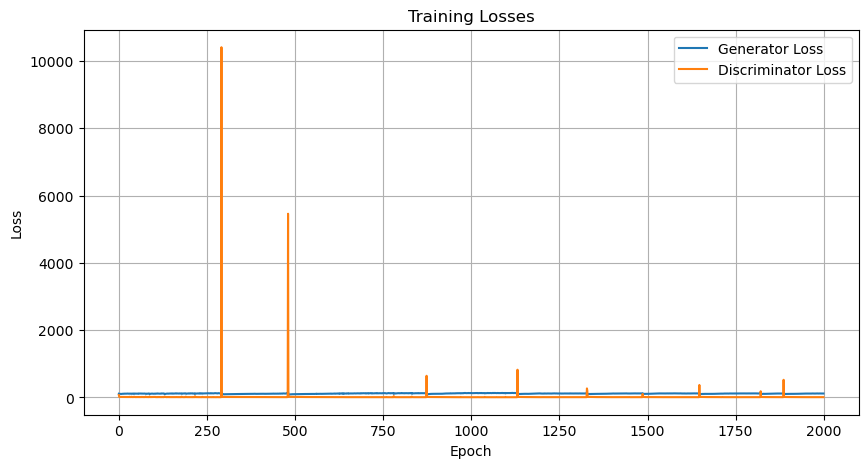

In [25]:
def plot_losses(g_loss, d_loss):
    plt.figure(figsize=(10, 5))
    plt.plot(g_loss, label="Generator Loss")
    plt.plot(d_loss, label="Discriminator Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Losses")
    plt.legend()
    plt.grid(True)
    plt.show()
plot_losses(g_losses, d_losses)


In [32]:
#import numpy as np
#from scipy.linalg import sqrtm

def calculate_fid(real_samples, generated_samples, feature_extractor):
    # Ensure the input has the correct shape for the feature extractor
    real_samples = real_samples.permute(0, 2, 1)  # Shape: [batch_size, 1, time_steps]
    generated_samples = generated_samples.permute(0, 2, 1)  # Shape: [batch_size, 1, time_steps]

    # Move to the same device as the feature extractor
    real_samples = real_samples.to(next(feature_extractor.parameters()).device)
    generated_samples = generated_samples.to(next(feature_extractor.parameters()).device)

    # Extract features using the feature extractor
    real_features = feature_extractor(real_samples).cpu().numpy()
    gen_features = feature_extractor(generated_samples).cpu().numpy()

    # Calculate the mean and covariance of the features
    real_mean = np.mean(real_features, axis=0)
    real_cov = np.cov(real_features, rowvar=False)
    gen_mean = np.mean(gen_features, axis=0)
    gen_cov = np.cov(gen_features, rowvar=False)

    # Ensure covariance matrices are 2D
    if real_cov.ndim == 0:
        real_cov = np.array([[real_cov]])
    if gen_cov.ndim == 0:
        gen_cov = np.array([[gen_cov]])

    # Calculate FID
    mean_diff = real_mean - gen_mean
    cov_sqrt = sqrtm(real_cov @ gen_cov)

    # Handle numerical issues with sqrtm producing complex values
    if np.iscomplexobj(cov_sqrt):
        cov_sqrt = cov_sqrt.real

    fid = np.sum(mean_diff**2) + np.trace(real_cov + gen_cov - 2 * cov_sqrt)
    return torch.tensor(fid, dtype=torch.float32)


In [33]:
def evaluate_model(generator, discriminator, test_loader, feature_extractor, device):
    generator.eval()
    discriminator.eval()

    with torch.no_grad():
        total_dtw_loss = 0.0
        total_waveform_loss = 0.0
        total_correlation = 0.0
        total_temporal_loss = 0.0
        total_fid = 0.0
        num_batches = len(test_loader)

        for real_data, labels in tqdm(test_loader):
            real_data, labels = real_data.to(device), labels.to(device)
            batch_size = real_data.size(0)

            # Generate fake data
            z = torch.randn(batch_size, 100).to(device)
            fake_data = generator(z, labels).permute(0, 2, 1)

            # Calculate metrics
            total_dtw_loss += dtw_loss(real_data, fake_data).item()
            total_waveform_loss += waveform_specific_loss(real_data, fake_data).item()
            total_correlation += calculate_correlation(real_data, fake_data).item()
            total_temporal_loss += temporal_coherence_loss(real_data, fake_data).item()
            total_fid += calculate_fid(real_data, fake_data, feature_extractor).item()

        print("Evaluation Metrics:")
        print(f"DTW Loss: {total_dtw_loss / num_batches:.4f}")
        print(f"Waveform Loss: {total_waveform_loss / num_batches:.4f}")
        print(f"Correlation: {total_correlation / num_batches:.4f}")
        print(f"Temporal Coherence Loss: {total_temporal_loss / num_batches:.4f}")
        print(f"FID: {total_fid / num_batches:.4f}")

# Evaluate the model after training
evaluate_model(generator, discriminator, val_loader, feature_extractor, device)


100%|██████████| 9/9 [00:00<00:00, 97.42it/s]

Evaluation Metrics:
DTW Loss: 0.5974
Waveform Loss: 0.5974
Correlation: 0.0042
Temporal Coherence Loss: 0.1333
FID: 0.0005


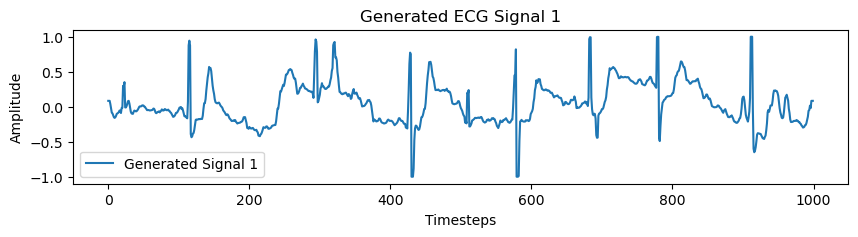

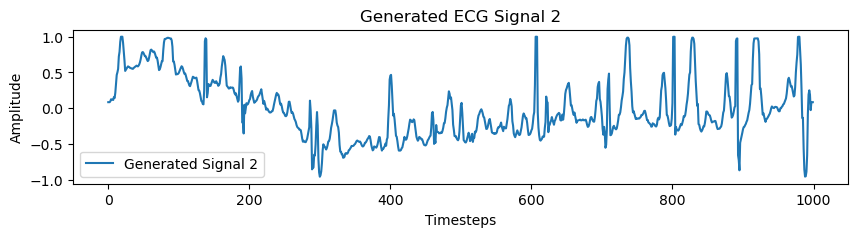

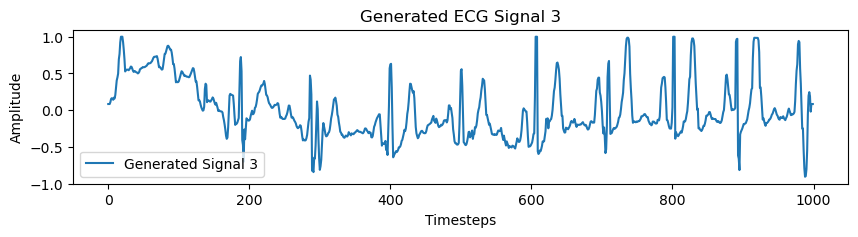

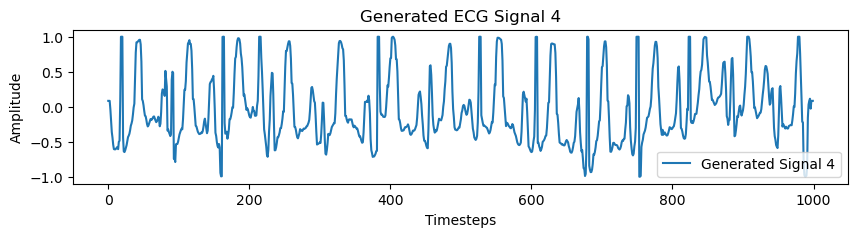

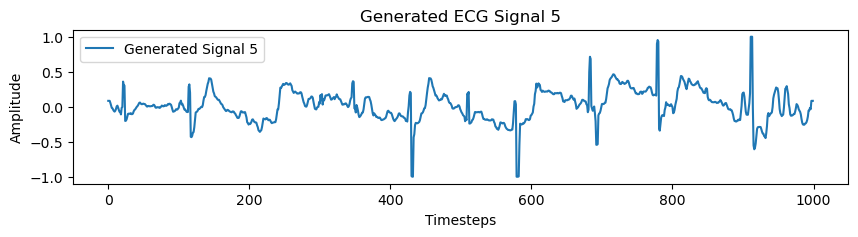

In [40]:


def plot_generated_ecgs(generator, num_samples=5, device='cpu'):
    """
    Plot generated ECG signals using the trained generator.
    """
    generator.eval()
    with torch.no_grad():
        # Generate random noise (latent space)
        z = torch.randn(num_samples, 100).to(device)  # Adjust latent_dim if needed
        # Generate labels (assume binary labels 0 or 1 for this example)
        labels = torch.randint(0, 2, (num_samples,)).to(device)
        # Generate fake ECG signals
        generated_data = generator(z, labels).cpu().numpy()
    
    # Plot each generated signal
    for i in range(num_samples):
        plt.figure(figsize=(10, 2))
        plt.plot(generated_data[i].squeeze(), label=f"Generated Signal {i+1}")
        plt.title(f"Generated ECG Signal {i+1}")
        plt.xlabel("Timesteps")
        plt.ylabel("Amplitude")
        plt.legend()
        plt.show()
plot_generated_ecgs(generator, num_samples=5, device=device)


Previous